### Operating Discriminator on Embedding Space instead of image space

Checking if GAN works fine if discriminator is made to differenciate on embedding space rather than image space. The embedding function $\phi$ is fixed with random weights.

<img src = 'images/emGAN.png' width=500 height=500/>

where **generator G** is fully convolutional as follows :-

<img src = 'images/emGAN_G.png' width=300 height=300/>

and **discriminator D** is densely connected as follows :-

<img src = 'images/emGAN_E.png' width=300 height=300/>

The **embedding network E** contains two convolutional layers initialized with random weights which are fixed. So, we can say that the embedding network is a fixed mapping from the output space of the generator to the input space of discriminator :- 

<img src = 'images/emGAN_D.png' width=300 height=300/>


In [21]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

Load images from MNIST and SVHN 

In [22]:
from model_exp0 import Generator, Discriminator, EmbeddingNet

In [23]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [24]:
batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

In [74]:
modelFolder = 'dummy'

GInitF = 'G_init.pt'
DInitF = 'D_init.pt'
EInitF = 'E_init.pt'

GFinalF = 'G_fin.pt'
DFinalF = 'D_fin.pt'
EFinalF = 'E_fin.pt'


def change():
    
    GInit = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator()
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator()
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'


In [71]:
def train(primaryTrainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    D = Discriminator()
    E = EmbeddingNet(numPrimaryOutputChannels)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    E.weight_init(mean=0.0, std=0.02)
    
    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EInitF
    torch.save(E.state_dict(), PATH)
    
    
    # setting the require_grad as False for all parameters pertaining thera and phi
    for param in E.parameters():
        param.require_grad=False
    
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numNoiseChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        E = E.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(primaryTrainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            discRealInputEmbedding = E(discRealInputV)
            
            #print discRealInputV.data.shape, discRealInputEmbedding.data.shape

            #print discRealInput.shape
            discRealOutput = D(discRealInputEmbedding)
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            genFakeOutputEmbedding = E(genFakeOutput)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutputEmbedding.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutputEmbedding)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EFinalF
    torch.save(E.state_dict(), PATH)

#### MNIST dataset

In [72]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/5] time: 0.91, loss_d: 1.359, loss_g: 0.694
Epoch : [2/5] time: 0.80, loss_d: 1.334, loss_g: 0.696
Epoch : [3/5] time: 0.80, loss_d: 1.348, loss_g: 0.674
Epoch : [4/5] time: 0.80, loss_d: 1.336, loss_g: 0.685
Epoch : [5/5] time: 0.80, loss_d: 1.317, loss_g: 0.697


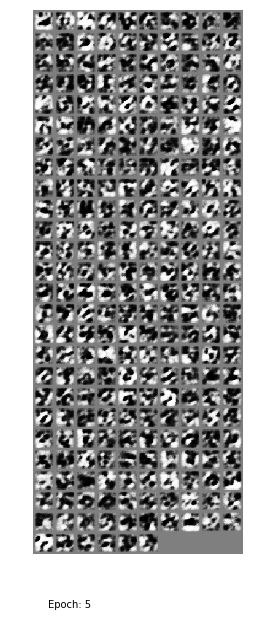

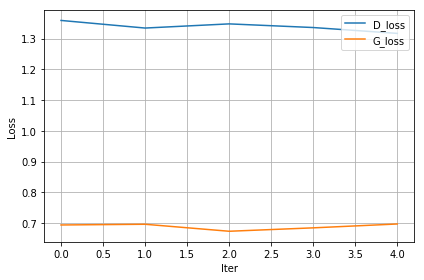

Generator : Weights changed
Discriminator : Weights changed
Embedding Network : Weights are same


In [38]:
train(primayTrainLoader, epochs=5)


In [73]:
change()

Here
Here
Generator: Weights are different
Discriminator: Weights are different
Embedding: Weights are same


Now running the same experiment for 30 epochs 

Epoch : [1/30] time: 0.97, loss_d: 1.376, loss_g: 0.752
Epoch : [2/30] time: 0.81, loss_d: 1.352, loss_g: 0.744
Epoch : [3/30] time: 0.81, loss_d: 1.336, loss_g: 0.739
Epoch : [4/30] time: 0.81, loss_d: 1.323, loss_g: 0.737
Epoch : [5/30] time: 0.81, loss_d: 1.307, loss_g: 0.741
Epoch : [6/30] time: 0.81, loss_d: 1.301, loss_g: 0.743
Epoch : [7/30] time: 0.81, loss_d: 1.317, loss_g: 0.737
Epoch : [8/30] time: 0.81, loss_d: 1.329, loss_g: 0.730
Epoch : [9/30] time: 0.81, loss_d: 1.336, loss_g: 0.729
Epoch : [10/30] time: 0.81, loss_d: 1.340, loss_g: 0.726
Epoch : [11/30] time: 0.81, loss_d: 1.342, loss_g: 0.727
Epoch : [12/30] time: 0.81, loss_d: 1.345, loss_g: 0.728
Epoch : [13/30] time: 0.81, loss_d: 1.348, loss_g: 0.726
Epoch : [14/30] time: 0.81, loss_d: 1.350, loss_g: 0.724
Epoch : [15/30] time: 0.81, loss_d: 1.353, loss_g: 0.724
Epoch : [16/30] time: 0.81, loss_d: 1.354, loss_g: 0.725
Epoch : [17/30] time: 0.81, loss_d: 1.359, loss_g: 0.724
Epoch : [18/30] time: 0.81, loss_d: 1.36

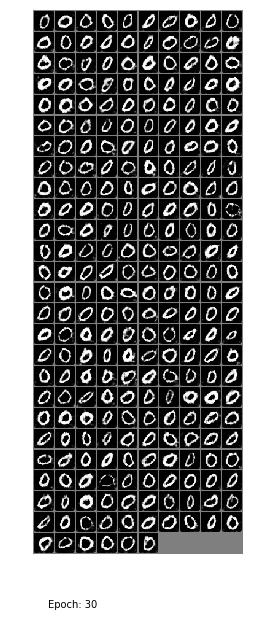

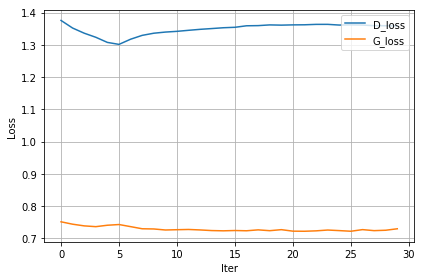

In [27]:
train(primayTrainLoader, epochs=30)

Epoch : [1/300] time: 1.00, loss_d: 1.367, loss_g: 0.641
Epoch : [2/300] time: 0.80, loss_d: 1.340, loss_g: 0.645
Epoch : [3/300] time: 0.81, loss_d: 1.319, loss_g: 0.652
Epoch : [4/300] time: 0.80, loss_d: 1.315, loss_g: 0.652
Epoch : [5/300] time: 0.81, loss_d: 1.308, loss_g: 0.660
Epoch : [6/300] time: 0.81, loss_d: 1.287, loss_g: 0.679
Epoch : [7/300] time: 0.81, loss_d: 1.274, loss_g: 0.692
Epoch : [8/300] time: 0.81, loss_d: 1.276, loss_g: 0.704
Epoch : [9/300] time: 0.80, loss_d: 1.303, loss_g: 0.704
Epoch : [10/300] time: 0.80, loss_d: 1.308, loss_g: 0.708
Epoch : [11/300] time: 0.81, loss_d: 1.311, loss_g: 0.713
Epoch : [12/300] time: 0.80, loss_d: 1.316, loss_g: 0.717
Epoch : [13/300] time: 0.83, loss_d: 1.320, loss_g: 0.721
Epoch : [14/300] time: 0.85, loss_d: 1.327, loss_g: 0.722
Epoch : [15/300] time: 0.82, loss_d: 1.334, loss_g: 0.723
Epoch : [16/300] time: 0.81, loss_d: 1.339, loss_g: 0.722
Epoch : [17/300] time: 0.81, loss_d: 1.346, loss_g: 0.721
Epoch : [18/300] time: 

Epoch : [142/300] time: 0.84, loss_d: 0.948, loss_g: 1.309
Epoch : [143/300] time: 0.84, loss_d: 0.945, loss_g: 1.328
Epoch : [144/300] time: 0.84, loss_d: 0.940, loss_g: 1.335
Epoch : [145/300] time: 0.83, loss_d: 0.926, loss_g: 1.344
Epoch : [146/300] time: 0.84, loss_d: 0.926, loss_g: 1.358
Epoch : [147/300] time: 0.84, loss_d: 0.913, loss_g: 1.387
Epoch : [148/300] time: 0.83, loss_d: 0.915, loss_g: 1.373
Epoch : [149/300] time: 0.83, loss_d: 0.906, loss_g: 1.402
Epoch : [150/300] time: 0.84, loss_d: 0.893, loss_g: 1.412
Epoch : [151/300] time: 0.83, loss_d: 0.895, loss_g: 1.408
Epoch : [152/300] time: 0.83, loss_d: 0.886, loss_g: 1.457
Epoch : [153/300] time: 0.83, loss_d: 0.893, loss_g: 1.447
Epoch : [154/300] time: 0.83, loss_d: 0.849, loss_g: 1.449
Epoch : [155/300] time: 0.83, loss_d: 0.871, loss_g: 1.453
Epoch : [156/300] time: 0.84, loss_d: 0.848, loss_g: 1.465
Epoch : [157/300] time: 0.83, loss_d: 0.842, loss_g: 1.487
Epoch : [158/300] time: 0.86, loss_d: 0.855, loss_g: 1.4

Epoch : [281/300] time: 0.83, loss_d: 0.403, loss_g: 2.945
Epoch : [282/300] time: 0.83, loss_d: 0.365, loss_g: 2.939
Epoch : [283/300] time: 0.83, loss_d: 0.370, loss_g: 2.947
Epoch : [284/300] time: 0.83, loss_d: 0.351, loss_g: 2.943
Epoch : [285/300] time: 0.83, loss_d: 0.345, loss_g: 2.916
Epoch : [286/300] time: 0.84, loss_d: 0.324, loss_g: 2.958
Epoch : [287/300] time: 0.83, loss_d: 0.326, loss_g: 2.935
Epoch : [288/300] time: 0.84, loss_d: 0.383, loss_g: 2.907
Epoch : [289/300] time: 0.83, loss_d: 0.337, loss_g: 2.982
Epoch : [290/300] time: 0.83, loss_d: 0.351, loss_g: 2.933
Epoch : [291/300] time: 0.83, loss_d: 0.301, loss_g: 2.954
Epoch : [292/300] time: 0.83, loss_d: 0.308, loss_g: 2.995
Epoch : [293/300] time: 0.83, loss_d: 0.312, loss_g: 3.024
Epoch : [294/300] time: 0.84, loss_d: 0.315, loss_g: 3.024
Epoch : [295/300] time: 0.83, loss_d: 0.307, loss_g: 3.015
Epoch : [296/300] time: 0.83, loss_d: 0.404, loss_g: 3.066
Epoch : [297/300] time: 0.84, loss_d: 0.379, loss_g: 3.0

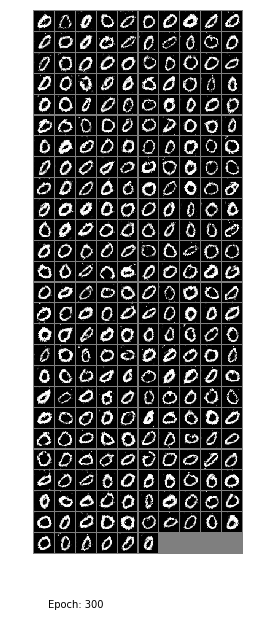

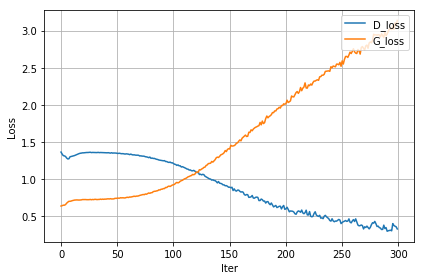

In [40]:
train(primayTrainLoader, epochs=300)

Epoch : [1/600] time: 0.84, loss_d: 1.365, loss_g: 0.737
Epoch : [2/600] time: 0.81, loss_d: 1.346, loss_g: 0.730
Epoch : [3/600] time: 0.81, loss_d: 1.344, loss_g: 0.716
Epoch : [4/600] time: 0.81, loss_d: 1.333, loss_g: 0.716
Epoch : [5/600] time: 0.81, loss_d: 1.317, loss_g: 0.721
Epoch : [6/600] time: 0.81, loss_d: 1.300, loss_g: 0.727
Epoch : [7/600] time: 0.81, loss_d: 1.287, loss_g: 0.735
Epoch : [8/600] time: 0.81, loss_d: 1.302, loss_g: 0.734
Epoch : [9/600] time: 0.81, loss_d: 1.338, loss_g: 0.723
Epoch : [10/600] time: 0.81, loss_d: 1.340, loss_g: 0.719
Epoch : [11/600] time: 0.81, loss_d: 1.343, loss_g: 0.721
Epoch : [12/600] time: 0.81, loss_d: 1.344, loss_g: 0.720
Epoch : [13/600] time: 0.81, loss_d: 1.349, loss_g: 0.717
Epoch : [14/600] time: 0.81, loss_d: 1.353, loss_g: 0.718
Epoch : [15/600] time: 0.81, loss_d: 1.358, loss_g: 0.714
Epoch : [16/600] time: 0.81, loss_d: 1.361, loss_g: 0.714
Epoch : [17/600] time: 0.81, loss_d: 1.363, loss_g: 0.713
Epoch : [18/600] time: 

Epoch : [142/600] time: 0.84, loss_d: 1.188, loss_g: 0.985
Epoch : [143/600] time: 0.84, loss_d: 1.186, loss_g: 0.985
Epoch : [144/600] time: 0.84, loss_d: 1.192, loss_g: 0.986
Epoch : [145/600] time: 0.84, loss_d: 1.177, loss_g: 1.005
Epoch : [146/600] time: 0.84, loss_d: 1.178, loss_g: 1.011
Epoch : [147/600] time: 0.84, loss_d: 1.172, loss_g: 1.004
Epoch : [148/600] time: 0.84, loss_d: 1.170, loss_g: 1.014
Epoch : [149/600] time: 0.84, loss_d: 1.171, loss_g: 1.019
Epoch : [150/600] time: 0.84, loss_d: 1.164, loss_g: 1.029
Epoch : [151/600] time: 0.84, loss_d: 1.148, loss_g: 1.026
Epoch : [152/600] time: 0.84, loss_d: 1.166, loss_g: 1.038
Epoch : [153/600] time: 0.84, loss_d: 1.168, loss_g: 1.042
Epoch : [154/600] time: 0.84, loss_d: 1.157, loss_g: 1.042
Epoch : [155/600] time: 0.84, loss_d: 1.161, loss_g: 1.045
Epoch : [156/600] time: 0.84, loss_d: 1.138, loss_g: 1.054
Epoch : [157/600] time: 0.84, loss_d: 1.150, loss_g: 1.056
Epoch : [158/600] time: 0.84, loss_d: 1.139, loss_g: 1.0

Epoch : [281/600] time: 0.84, loss_d: 0.853, loss_g: 1.757
Epoch : [282/600] time: 0.84, loss_d: 0.829, loss_g: 1.746
Epoch : [283/600] time: 0.84, loss_d: 0.832, loss_g: 1.734
Epoch : [284/600] time: 0.84, loss_d: 0.823, loss_g: 1.741
Epoch : [285/600] time: 0.84, loss_d: 0.827, loss_g: 1.762
Epoch : [286/600] time: 0.84, loss_d: 0.828, loss_g: 1.779
Epoch : [287/600] time: 0.84, loss_d: 0.834, loss_g: 1.775
Epoch : [288/600] time: 0.84, loss_d: 0.953, loss_g: 1.739
Epoch : [289/600] time: 0.84, loss_d: 0.921, loss_g: 1.851
Epoch : [290/600] time: 0.84, loss_d: 0.805, loss_g: 1.851
Epoch : [291/600] time: 0.84, loss_d: 0.830, loss_g: 1.791
Epoch : [292/600] time: 0.84, loss_d: 0.822, loss_g: 1.776
Epoch : [293/600] time: 0.84, loss_d: 0.815, loss_g: 1.757
Epoch : [294/600] time: 0.84, loss_d: 0.808, loss_g: 1.790
Epoch : [295/600] time: 0.84, loss_d: 0.799, loss_g: 1.817
Epoch : [296/600] time: 0.84, loss_d: 0.797, loss_g: 1.798
Epoch : [297/600] time: 0.84, loss_d: 0.820, loss_g: 1.8

Epoch : [420/600] time: 0.84, loss_d: 0.642, loss_g: 2.434
Epoch : [421/600] time: 0.84, loss_d: 0.620, loss_g: 2.450
Epoch : [422/600] time: 0.84, loss_d: 0.619, loss_g: 2.484
Epoch : [423/600] time: 0.84, loss_d: 0.585, loss_g: 2.491
Epoch : [424/600] time: 0.84, loss_d: 0.617, loss_g: 2.418
Epoch : [425/600] time: 0.84, loss_d: 0.579, loss_g: 2.498
Epoch : [426/600] time: 0.84, loss_d: 0.618, loss_g: 2.503
Epoch : [427/600] time: 0.84, loss_d: 0.604, loss_g: 2.449
Epoch : [428/600] time: 0.84, loss_d: 0.610, loss_g: 2.443
Epoch : [429/600] time: 0.84, loss_d: 0.570, loss_g: 2.503
Epoch : [430/600] time: 0.84, loss_d: 0.611, loss_g: 2.426
Epoch : [431/600] time: 0.84, loss_d: 0.564, loss_g: 2.507
Epoch : [432/600] time: 0.84, loss_d: 0.631, loss_g: 2.508
Epoch : [433/600] time: 0.84, loss_d: 0.596, loss_g: 2.479
Epoch : [434/600] time: 0.84, loss_d: 0.600, loss_g: 2.474
Epoch : [435/600] time: 0.84, loss_d: 0.611, loss_g: 2.508
Epoch : [436/600] time: 0.84, loss_d: 0.593, loss_g: 2.5

Epoch : [559/600] time: 0.84, loss_d: 0.409, loss_g: 3.165
Epoch : [560/600] time: 0.84, loss_d: 0.410, loss_g: 3.095
Epoch : [561/600] time: 0.84, loss_d: 0.398, loss_g: 3.077
Epoch : [562/600] time: 0.84, loss_d: 0.405, loss_g: 3.170
Epoch : [563/600] time: 0.84, loss_d: 0.418, loss_g: 3.117
Epoch : [564/600] time: 0.84, loss_d: 0.439, loss_g: 3.133
Epoch : [565/600] time: 0.84, loss_d: 0.496, loss_g: 3.251
Epoch : [566/600] time: 0.84, loss_d: 0.424, loss_g: 3.184
Epoch : [567/600] time: 0.83, loss_d: 0.447, loss_g: 3.129
Epoch : [568/600] time: 0.84, loss_d: 0.448, loss_g: 3.159
Epoch : [569/600] time: 0.84, loss_d: 0.410, loss_g: 3.163
Epoch : [570/600] time: 0.84, loss_d: 0.391, loss_g: 3.156
Epoch : [571/600] time: 0.84, loss_d: 0.411, loss_g: 3.165
Epoch : [572/600] time: 0.84, loss_d: 0.405, loss_g: 3.236
Epoch : [573/600] time: 0.84, loss_d: 0.422, loss_g: 3.132
Epoch : [574/600] time: 0.84, loss_d: 0.383, loss_g: 3.149
Epoch : [575/600] time: 0.84, loss_d: 0.395, loss_g: 3.1

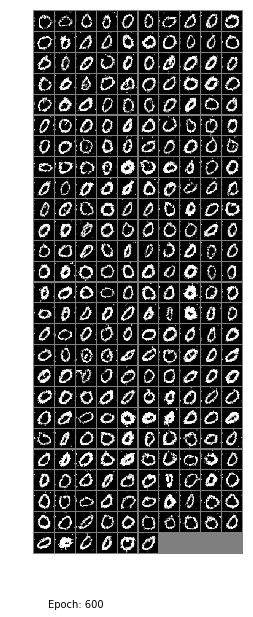

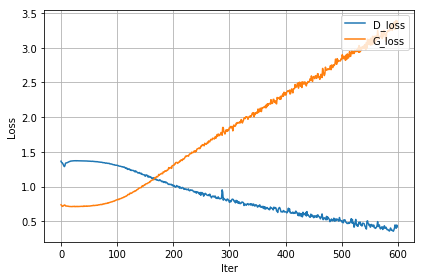

In [42]:
train(primayTrainLoader, epochs=600)

For another class of MNIST dataset

In [7]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [5]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/30] time: 0.78, loss_d: 1.355, loss_g: 0.646
Epoch : [2/30] time: 0.74, loss_d: 1.339, loss_g: 0.646
Epoch : [3/30] time: 0.75, loss_d: 1.332, loss_g: 0.646
Epoch : [4/30] time: 0.74, loss_d: 1.316, loss_g: 0.654
Epoch : [5/30] time: 0.74, loss_d: 1.293, loss_g: 0.667
Epoch : [6/30] time: 0.75, loss_d: 1.268, loss_g: 0.684
Epoch : [7/30] time: 0.75, loss_d: 1.248, loss_g: 0.701
Epoch : [8/30] time: 0.75, loss_d: 1.257, loss_g: 0.703
Epoch : [9/30] time: 0.74, loss_d: 1.293, loss_g: 0.704
Epoch : [10/30] time: 0.74, loss_d: 1.289, loss_g: 0.711
Epoch : [11/30] time: 0.74, loss_d: 1.292, loss_g: 0.709
Epoch : [12/30] time: 0.75, loss_d: 1.285, loss_g: 0.721
Epoch : [13/30] time: 0.74, loss_d: 1.294, loss_g: 0.722
Epoch : [14/30] time: 0.74, loss_d: 1.298, loss_g: 0.723
Epoch : [15/30] time: 0.74, loss_d: 1.300, loss_g: 0.728
Epoch : [16/30] time: 0.75, loss_d: 1.301, loss_g: 0.734
Epoch : [17/30] time: 0.75, loss_d: 1.302, loss_g: 0.736
Epoch : [18/30] time: 0.75, loss_d: 1.30

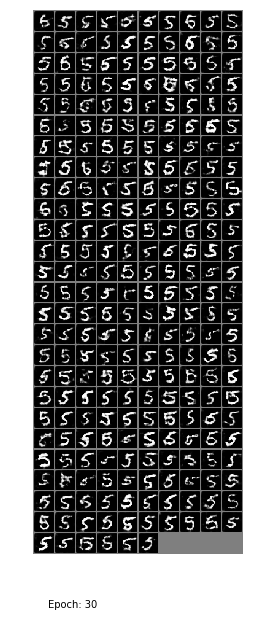

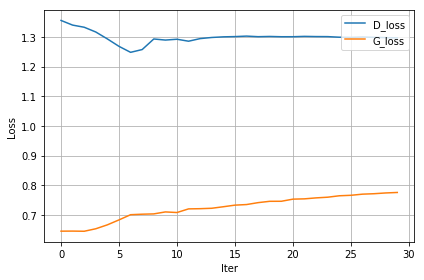

In [50]:
train(primayTrainLoader, epochs=30)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/300] time: 4.92, loss_d: 1.359, loss_g: 0.689
Epoch : [2/300] time: 0.71, loss_d: 1.338, loss_g: 0.692
Epoch : [3/300] time: 0.72, loss_d: 1.318, loss_g: 0.697
Epoch : [4/300] time: 0.72, loss_d: 1.303, loss_g: 0.703
Epoch : [5/300] time: 0.72, loss_d: 1.292, loss_g: 0.708
Epoch : [6/300] time: 0.72, loss_d: 1.284, loss_g: 0.713
Epoch : [7/300] time: 0.72, loss_d: 1.260, loss_g: 0.730
Epoch : [8/300] time: 0.72, loss_d: 1.228, loss_g: 0.761
Epoch : [9/300] time: 0.72, loss_d: 1.212, loss_g: 0.772
Epoch : [10/300] time: 0.72, loss_d: 1.240, loss_g: 0.761
Epoch : [11/300] time: 0.72, loss_d: 1.286, loss_g: 0.739
Epoch : [12/300] time: 0.72, loss_d: 1.298, loss_g: 0.741
Epoch : [13/300] time: 0.72, loss_d: 1.308, loss_g: 0.735
Epoch : [14/300] time: 0.72, loss_d: 1.309, loss_g: 0.733
Epoch : [15/300] time: 0.72, loss_d: 1.310, loss_g: 0.735
Epoch : [16/300] time: 0.72, loss_d: 1.309, loss_g: 0.733
Epoch : [17/300] time: 0.72, loss_d: 1.308, loss_g: 0.740
Epoch : [18/300] time: 

Epoch : [142/300] time: 0.75, loss_d: 0.887, loss_g: 1.435
Epoch : [143/300] time: 0.75, loss_d: 0.877, loss_g: 1.425
Epoch : [144/300] time: 0.75, loss_d: 0.882, loss_g: 1.454
Epoch : [145/300] time: 0.75, loss_d: 0.868, loss_g: 1.470
Epoch : [146/300] time: 0.74, loss_d: 0.869, loss_g: 1.472
Epoch : [147/300] time: 0.74, loss_d: 0.855, loss_g: 1.478
Epoch : [148/300] time: 0.74, loss_d: 0.852, loss_g: 1.505
Epoch : [149/300] time: 0.74, loss_d: 0.842, loss_g: 1.510
Epoch : [150/300] time: 0.74, loss_d: 0.854, loss_g: 1.511
Epoch : [151/300] time: 0.74, loss_d: 0.822, loss_g: 1.529
Epoch : [152/300] time: 0.74, loss_d: 0.838, loss_g: 1.550
Epoch : [153/300] time: 0.74, loss_d: 0.822, loss_g: 1.540
Epoch : [154/300] time: 0.74, loss_d: 0.822, loss_g: 1.568
Epoch : [155/300] time: 0.74, loss_d: 0.829, loss_g: 1.575
Epoch : [156/300] time: 0.74, loss_d: 0.813, loss_g: 1.560
Epoch : [157/300] time: 0.75, loss_d: 0.787, loss_g: 1.607
Epoch : [158/300] time: 0.74, loss_d: 0.793, loss_g: 1.6

Epoch : [281/300] time: 0.75, loss_d: 0.371, loss_g: 2.820
Epoch : [282/300] time: 0.74, loss_d: 0.359, loss_g: 2.874
Epoch : [283/300] time: 0.75, loss_d: 0.384, loss_g: 2.896
Epoch : [284/300] time: 0.75, loss_d: 0.413, loss_g: 2.865
Epoch : [285/300] time: 0.75, loss_d: 0.424, loss_g: 2.884
Epoch : [286/300] time: 0.74, loss_d: 0.402, loss_g: 2.851
Epoch : [287/300] time: 0.74, loss_d: 0.342, loss_g: 2.895
Epoch : [288/300] time: 0.74, loss_d: 0.363, loss_g: 2.930
Epoch : [289/300] time: 0.74, loss_d: 0.361, loss_g: 2.917
Epoch : [290/300] time: 0.75, loss_d: 0.374, loss_g: 2.948
Epoch : [291/300] time: 0.75, loss_d: 0.353, loss_g: 2.909
Epoch : [292/300] time: 0.74, loss_d: 0.378, loss_g: 2.907
Epoch : [293/300] time: 0.74, loss_d: 0.343, loss_g: 2.942
Epoch : [294/300] time: 0.74, loss_d: 0.392, loss_g: 2.956
Epoch : [295/300] time: 0.74, loss_d: 0.355, loss_g: 3.026
Epoch : [296/300] time: 0.74, loss_d: 0.343, loss_g: 2.984
Epoch : [297/300] time: 0.75, loss_d: 0.327, loss_g: 2.9

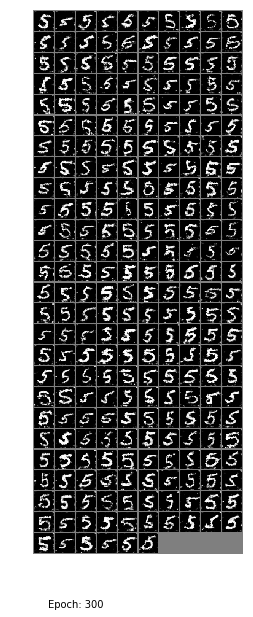

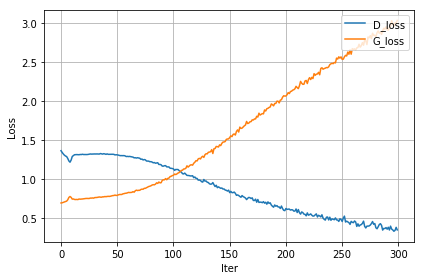

In [8]:
train(primayTrainLoader, epochs=300)

#### SVHN Dataset

In [43]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/5] time: 0.85, loss_d: 1.372, loss_g: 0.700
Epoch : [2/5] time: 0.83, loss_d: 1.353, loss_g: 0.702
Epoch : [3/5] time: 0.81, loss_d: 1.362, loss_g: 0.692
Epoch : [4/5] time: 0.81, loss_d: 1.366, loss_g: 0.694
Epoch : [5/5] time: 0.82, loss_d: 1.367, loss_g: 0.699


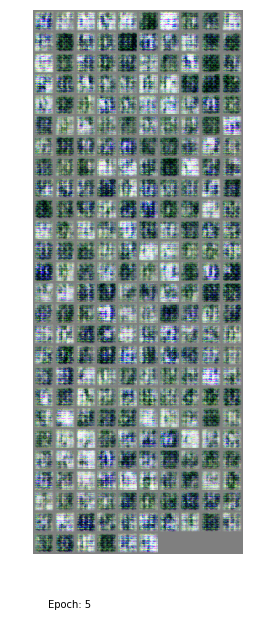

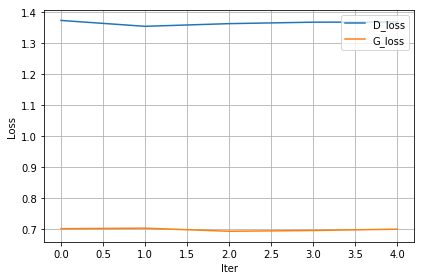

In [36]:
train(primayTrainLoader, epochs=5)

Epoch : [1/30] time: 0.80, loss_d: 1.371, loss_g: 0.723
Epoch : [2/30] time: 0.82, loss_d: 1.360, loss_g: 0.718
Epoch : [3/30] time: 0.82, loss_d: 1.359, loss_g: 0.708
Epoch : [4/30] time: 0.82, loss_d: 1.367, loss_g: 0.704
Epoch : [5/30] time: 0.81, loss_d: 1.376, loss_g: 0.701
Epoch : [6/30] time: 0.82, loss_d: 1.374, loss_g: 0.704
Epoch : [7/30] time: 0.81, loss_d: 1.381, loss_g: 0.698
Epoch : [8/30] time: 0.82, loss_d: 1.379, loss_g: 0.700
Epoch : [9/30] time: 0.82, loss_d: 1.381, loss_g: 0.700
Epoch : [10/30] time: 0.82, loss_d: 1.382, loss_g: 0.701
Epoch : [11/30] time: 0.82, loss_d: 1.383, loss_g: 0.700
Epoch : [12/30] time: 0.82, loss_d: 1.382, loss_g: 0.700
Epoch : [13/30] time: 0.81, loss_d: 1.382, loss_g: 0.699
Epoch : [14/30] time: 0.82, loss_d: 1.381, loss_g: 0.701
Epoch : [15/30] time: 0.82, loss_d: 1.379, loss_g: 0.703
Epoch : [16/30] time: 0.81, loss_d: 1.379, loss_g: 0.701
Epoch : [17/30] time: 0.82, loss_d: 1.378, loss_g: 0.701
Epoch : [18/30] time: 0.82, loss_d: 1.37

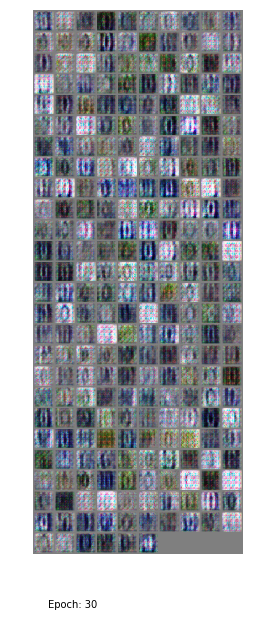

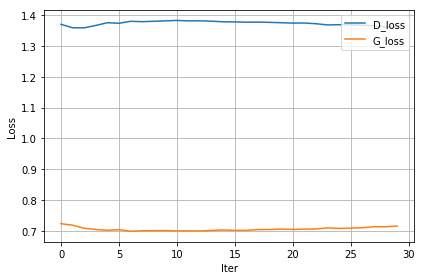

In [37]:
train(primayTrainLoader, epochs=30)

Epoch : [1/300] time: 0.84, loss_d: 1.371, loss_g: 0.729
Epoch : [2/300] time: 0.81, loss_d: 1.350, loss_g: 0.730
Epoch : [3/300] time: 0.82, loss_d: 1.351, loss_g: 0.717
Epoch : [4/300] time: 0.81, loss_d: 1.352, loss_g: 0.710
Epoch : [5/300] time: 0.82, loss_d: 1.350, loss_g: 0.710
Epoch : [6/300] time: 0.82, loss_d: 1.372, loss_g: 0.696
Epoch : [7/300] time: 0.82, loss_d: 1.376, loss_g: 0.699
Epoch : [8/300] time: 0.81, loss_d: 1.373, loss_g: 0.707
Epoch : [9/300] time: 0.82, loss_d: 1.378, loss_g: 0.702
Epoch : [10/300] time: 0.82, loss_d: 1.381, loss_g: 0.706
Epoch : [11/300] time: 0.82, loss_d: 1.382, loss_g: 0.704
Epoch : [12/300] time: 0.82, loss_d: 1.382, loss_g: 0.703
Epoch : [13/300] time: 0.82, loss_d: 1.383, loss_g: 0.702
Epoch : [14/300] time: 0.82, loss_d: 1.383, loss_g: 0.699
Epoch : [15/300] time: 0.81, loss_d: 1.381, loss_g: 0.699
Epoch : [16/300] time: 0.82, loss_d: 1.381, loss_g: 0.700
Epoch : [17/300] time: 0.82, loss_d: 1.382, loss_g: 0.697
Epoch : [18/300] time: 

Epoch : [142/300] time: 0.84, loss_d: 1.319, loss_g: 0.769
Epoch : [143/300] time: 0.84, loss_d: 1.312, loss_g: 0.775
Epoch : [144/300] time: 0.84, loss_d: 1.314, loss_g: 0.768
Epoch : [145/300] time: 0.84, loss_d: 1.315, loss_g: 0.775
Epoch : [146/300] time: 0.84, loss_d: 1.307, loss_g: 0.776
Epoch : [147/300] time: 0.84, loss_d: 1.310, loss_g: 0.780
Epoch : [148/300] time: 0.84, loss_d: 1.307, loss_g: 0.778
Epoch : [149/300] time: 0.84, loss_d: 1.309, loss_g: 0.782
Epoch : [150/300] time: 0.84, loss_d: 1.306, loss_g: 0.785
Epoch : [151/300] time: 0.84, loss_d: 1.301, loss_g: 0.789
Epoch : [152/300] time: 0.84, loss_d: 1.297, loss_g: 0.788
Epoch : [153/300] time: 0.84, loss_d: 1.298, loss_g: 0.786
Epoch : [154/300] time: 0.84, loss_d: 1.302, loss_g: 0.788
Epoch : [155/300] time: 0.84, loss_d: 1.301, loss_g: 0.794
Epoch : [156/300] time: 0.84, loss_d: 1.295, loss_g: 0.789
Epoch : [157/300] time: 0.84, loss_d: 1.282, loss_g: 0.798
Epoch : [158/300] time: 0.84, loss_d: 1.295, loss_g: 0.7

Epoch : [281/300] time: 0.84, loss_d: 1.021, loss_g: 1.134
Epoch : [282/300] time: 0.84, loss_d: 1.052, loss_g: 1.140
Epoch : [283/300] time: 0.84, loss_d: 1.019, loss_g: 1.154
Epoch : [284/300] time: 0.84, loss_d: 1.066, loss_g: 1.088
Epoch : [285/300] time: 0.84, loss_d: 1.051, loss_g: 1.115
Epoch : [286/300] time: 0.84, loss_d: 1.040, loss_g: 1.142
Epoch : [287/300] time: 0.84, loss_d: 1.004, loss_g: 1.147
Epoch : [288/300] time: 0.84, loss_d: 1.009, loss_g: 1.153
Epoch : [289/300] time: 0.84, loss_d: 1.021, loss_g: 1.156
Epoch : [290/300] time: 0.84, loss_d: 0.992, loss_g: 1.183
Epoch : [291/300] time: 0.84, loss_d: 0.996, loss_g: 1.163
Epoch : [292/300] time: 0.84, loss_d: 0.983, loss_g: 1.158
Epoch : [293/300] time: 0.84, loss_d: 1.028, loss_g: 1.122
Epoch : [294/300] time: 0.84, loss_d: 0.991, loss_g: 1.180
Epoch : [295/300] time: 0.85, loss_d: 1.009, loss_g: 1.182
Epoch : [296/300] time: 0.84, loss_d: 1.027, loss_g: 1.171
Epoch : [297/300] time: 0.84, loss_d: 0.974, loss_g: 1.1

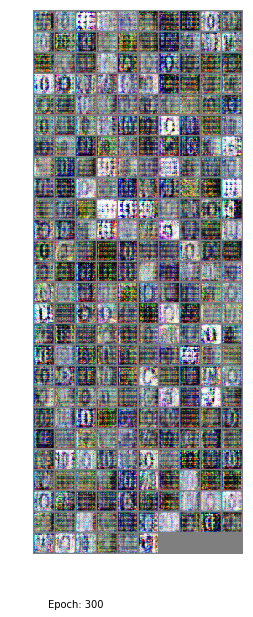

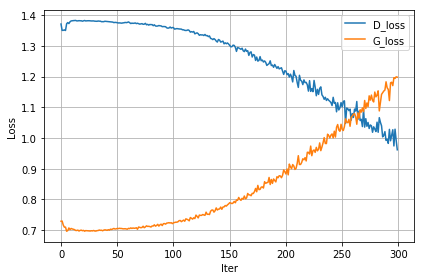

In [46]:
train(primayTrainLoader, epochs=300)